# 6.6 Sourcing & Analyzing Time-Series Data

### 1. Importing your libraries and data

Before you start this analysis, you'll need a new library you haven't installed before—Quandl. Install Quandl using conda:

`conda install quandl`

In [3]:
conda install quandl

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\gullo\anaconda3

  added / updated specs:
    - quandl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.05.30 |       haa95532_0         120 KB
    certifi-2023.7.22          |  py310haa95532_0         154 KB
    more-itertools-8.12.0      |     pyhd3eb1b0_0          49 KB
    openssl-1.1.1v             |       h2bbff1b_0         5.5 MB
    quandl-3.6.1               |  py310haa95532_0          53 KB
    ------------------------------------------------------------
                                           Total:         5.9 MB

The following NEW packages will be INSTALLED:

  more-itertools     pkgs/main/noarch::more-itertools-8.12.0-pyhd3eb1b0_0 
  quandl             pkgs/main/win-64::quandl-3.6.1-py310haa95532_0 

The following packages will be UPDATED:

  ca-certificate



==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.7.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.2




In [4]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [5]:
# Configure API key 

quandl.ApiConfig.api_key = 'co9CvxnLyL_xr_SgfXyP'

In [48]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('FRED/GDP')

In [49]:
data.head(5)

,Value
Date,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742


In [50]:
data.shape

(300, 1)

In [51]:
data.columns

Index(['Value'], dtype='object')

In [52]:
type(data)

pandas.core.frame.DataFrame

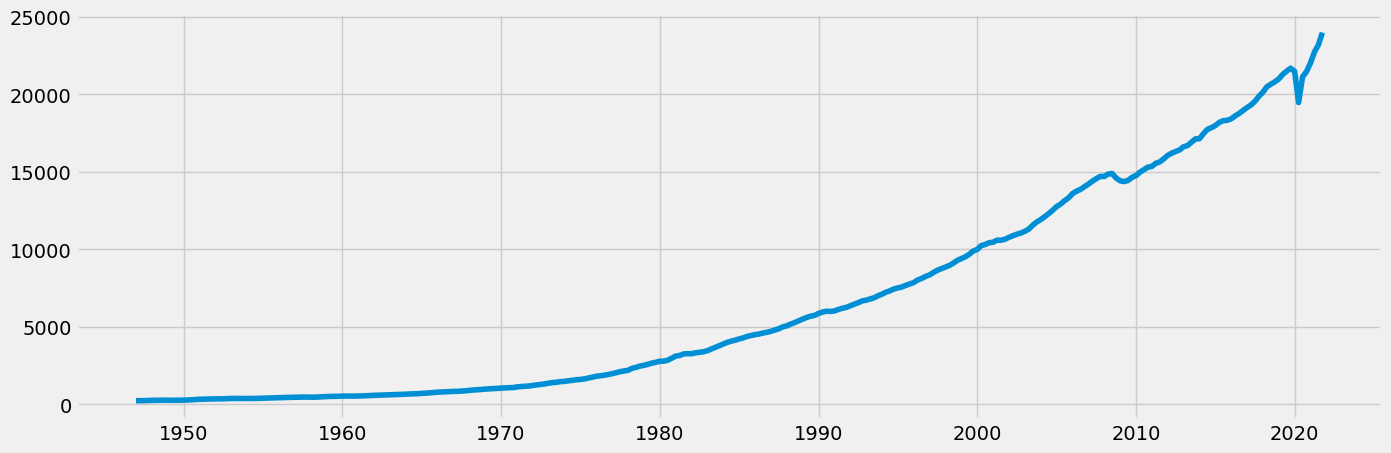

In [53]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

#### The data includes observations from around 1947 to present day.

### 2. Subsetting, wrangling, and cleaning time-series data

In [54]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [55]:
data_2.head()

,Date,Value
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


In [56]:
data_2.tail()

,Date,Value
295,2020-10-01,21477.597
296,2021-01-01,22038.226
297,2021-04-01,22740.959
298,2021-07-01,23202.344
299,2021-10-01,23992.355


In [57]:
data_sub = data_2.loc[(data_2['Date'] >= '2000-01-01') & (data_2['Date'] < '2021-01-01')]

In [58]:
data_sub.shape

(84, 2)

In [59]:
data_sub.head()

,Date,Value
212,2000-01-01,10002.179
213,2000-04-01,10247.720
214,2000-07-01,10318.165
215,2000-10-01,10435.744
216,2001-01-01,10470.231


In [60]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2000-01-01,10002.179
2000-04-01,10247.720
2000-07-01,10318.165
2000-10-01,10435.744
2001-01-01,10470.231


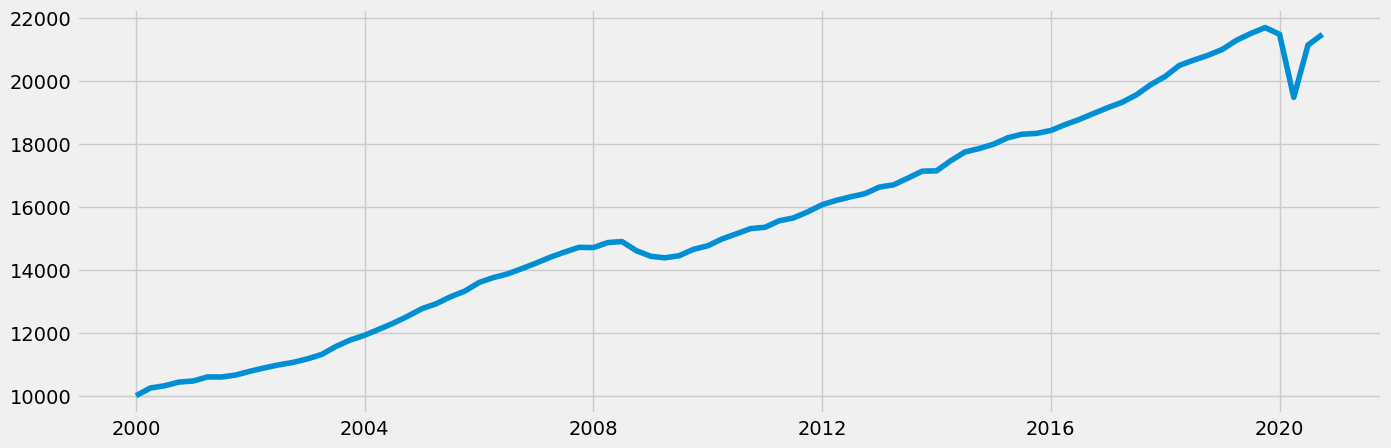

In [61]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [62]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [63]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()


0

### 3. Time-series analysis: decomposition

In [64]:
import statsmodels.api as sm

In [65]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')


In [66]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

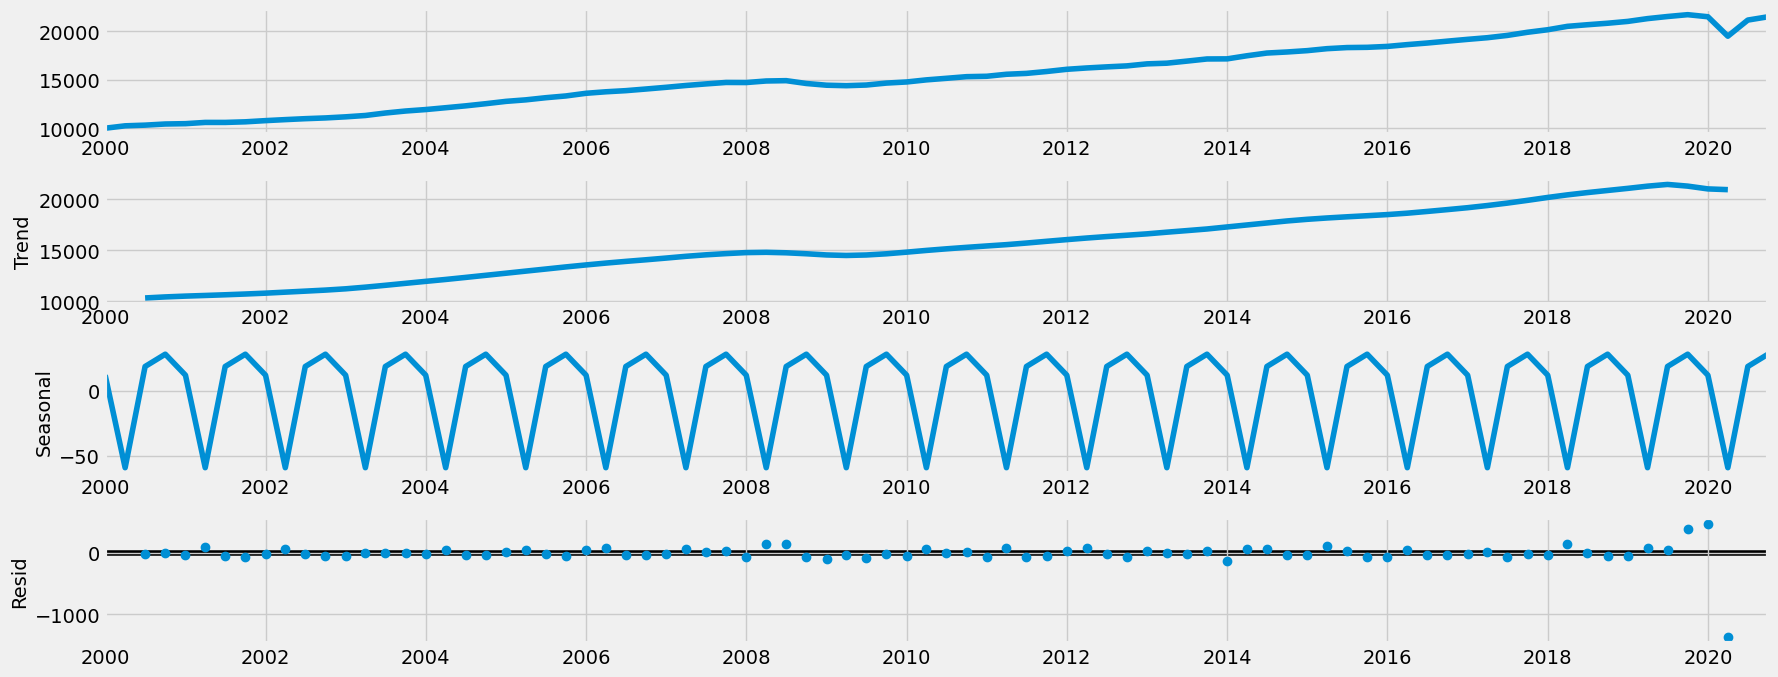

In [67]:
# Plot the separate components

decomposition.plot()
plt.show()

### Observations:

#### The trend in the chart above gradually increases in a linear fashion after 2004. While there’s one drop around 2009, likely due to the global financial crisis, the overall trend continues to decrease all the way until the present year.

#### In seasonality, there are seasonal fluctuations represented by a spikey curve that changes at a regular interval. 

#### In Resid, there isn’t much unexplained noise except after 2018

### 4. Testing for stationarity

In [68]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -0.149458
p-value                         0.944284
Number of Lags Used             2.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


####    Test Statistic: -0.149458 - The test statistic is negative but close to zero, indicating that the time series is likely not stationary.

####    p-value: 0.944284 - In this case, the high p-value suggests that you do not have enough evidence to reject the null hypothesis.

####    Number of Lags Used: 2 - This indicates the number of lag observations included in the regression when calculating the test statistic. In this case, 2 lags were used.

####    Number of Observations Used: 81 - This represents the number of observations used in the test. In your case, 81 observations were used.

####    Critical Values - The test statistic is greater than all the critical values, which supports the observation that the time series is likely not stationary.

### In summary, based on the high p-value and the test statistic not being significantly lower than the critical values, I cannot reject the null hypothesis of non-stationarity. This suggests that the time series is likely not stationary and may require differencing or other transformations to achieve stationarity before applying time series analysis techniques.

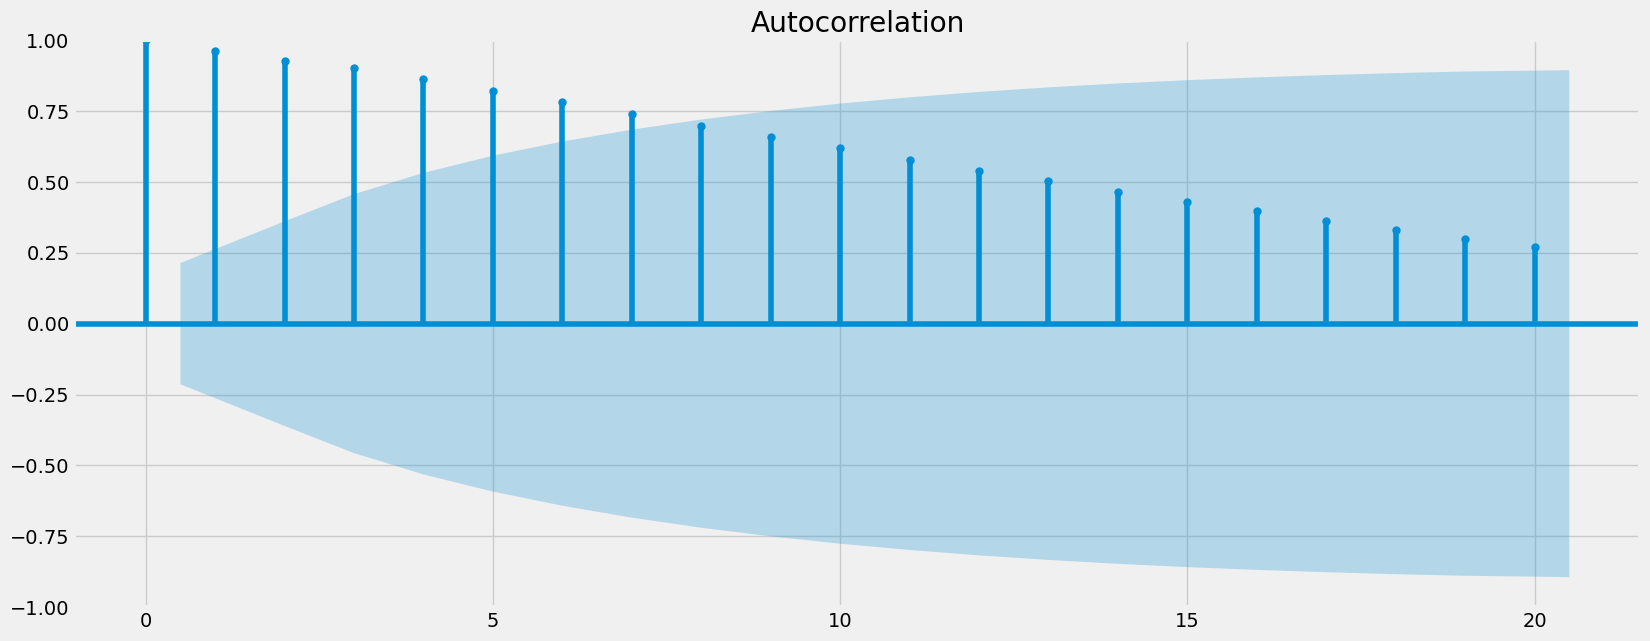

In [69]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### 5. Stationarizing the U.S. Energy Information Administration Data

In [70]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [71]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [72]:
data_diff.head()

,Value
datetime,
2000-04-01,245.541
2000-07-01,70.445
2000-10-01,117.579
2001-01-01,34.487
2001-04-01,128.769


In [73]:
data_diff.columns

Index(['Value'], dtype='object')

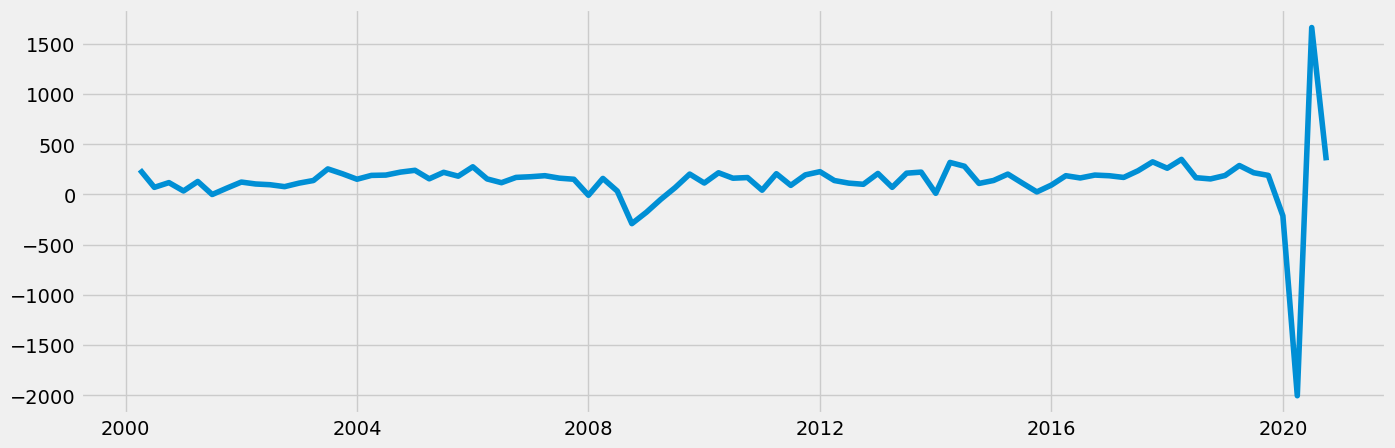

In [74]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [75]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -7.774492e+00
p-value                        8.742616e-12
Number of Lags Used            1.000000e+00
Number of Observations Used    8.100000e+01
Critical Value (1%)           -3.513790e+00
Critical Value (5%)           -2.897943e+00
Critical Value (10%)          -2.586191e+00
dtype: float64


####    Test Statistic: -7.774492e+00 - The test statistic is significantly negative, indicating that the time series is likely stationary.

####    p-value: 8.742616e-12 - This suggests that I can reject the null hypothesis and conclude that the time series is stationary.

####    Number of Lags Used: 1 - This indicates the number of lag observations included in the regression when calculating the test statistic. In this case, 1 lag was used.

####    Number of Observations Used: 81 - This represents the number of observations used in the test. In this case, 81 observations were used.

####    Critical Values - In this case, the test statistic is significantly lower than all the critical values, which supports the conclusion that the time series is stationary.

### In summary, both the highly negative test statistic and the very low p-value suggest that the differenced time series (data_diff) is stationary. This means that the differenced series likely does not exhibit trends or seasonality and is suitable for further time series analysis techniques that assume stationarity.

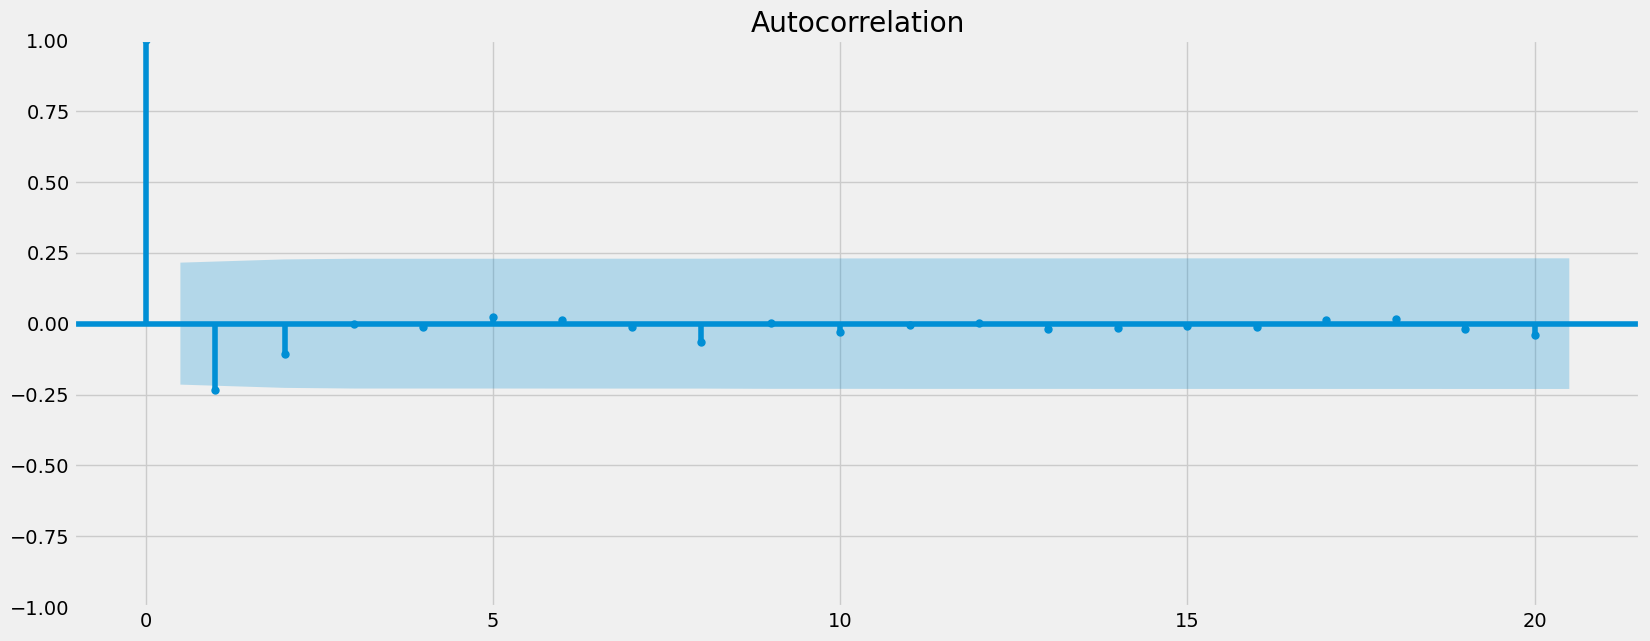

In [76]:
plot_acf(data_diff)
plt.show()